In [1]:
NUPLAN_DATA_ROOT = "/home/PJLAB/weitiantian/data/Nuplan"
NUPLAN_MAP_VERSION = "nuplan-maps-v1.0"
NUPLAN_MAPS_ROOT = "/home/PJLAB/weitiantian/data/Nuplan/maps"
NUPLAN_SENSOR_ROOT = f"{NUPLAN_DATA_ROOT}/nuplan-v1.1/sensor_blobs"
TEST_DB_FILE = f"{NUPLAN_DATA_ROOT}/nuplan-v1.1/splits/mini/2021.05.12.22.00.38_veh-35_01008_01518.db"
MAP_NAME = "us-nv-las-vegas"

In [2]:
from nuplan.database.maps_db.gpkg_mapsdb import GPKGMapsDB
from nuplan.common.maps.nuplan_map.nuplan_map import NuPlanMap
from nuplan.database.maps_db.map_api import NuPlanMapWrapper
from nuplan.database.maps_db.map_explorer import NuPlanMapExplorer

from nuplan.database.nuplan_db_orm.nuplandb import NuPlanDB



map_version = 'nuplan-maps-v1.0'
map_name = 'us-nv-las-vegas-strip'
NUPLAN_MAPS_ROOT #predefinded
mapdb = GPKGMapsDB(map_version, NUPLAN_MAPS_ROOT)
nuplan_map = NuPlanMap(mapdb,map_name='us-nv-las-vegas-strip')
map_api = NuPlanMapWrapper(mapdb,map_name='us-nv-las-vegas-strip')
map_explorer = NuPlanMapExplorer(map_api=map_api)

nuplandb = NuPlanDB(data_root=NUPLAN_DATA_ROOT, load_path=TEST_DB_FILE,maps_db=mapdb, verbose=True)
radius = 50

In [3]:
# extract samples
from nuplan.database.nuplan_db_orm.rendering_utils import lidar_pc_closest_image

sample_idx = 4000
lidar_sample = nuplandb.lidar_pc[sample_idx]
ego_pose_sample = lidar_sample.ego_pose


In [4]:
# map feature visualization
import matplotlib.pyplot as plt

def visualize_map_features(features):
    """
    Visualize map features including polylines and polygons using matplotlib,
    ensuring each type is only labeled once in the legend. Polygons are filled with color, and each data type has a unique color.
    
    :param features: Dictionary of features to visualize. Each key is an feature ID, 
                     each value is another dict with 'polyline' and 'polygon'.
    """
    fig, ax = plt.subplots(figsize=(25, 25))
    ax.set_aspect('equal', adjustable='datalim')
    plt.grid(False)

    # Prepare color mapping for each type
    types = set(data['type'] for data in features.values())
    type_to_color = {'ROAD_LINE_SOLID_SINGLE_WHITE': 'red',
                     'ROAD_LINE_BROKEN_SINGLE_WHITE': 'blue',
                     'CROSSWALK': 'magenta'}

    legend_labels = set()

    for feature_id, data in features.items():
        # if data['type'] == 'ROAD_LINE_SOLID_SINGLE_WHITE' or data['type'] == 'ROAD_LINE_BROKEN_SINGLE_WHITE' or data['type'] == 'CROSSWALK':
        #     print(features[feature_id])
        label = data['type'] if data['type'] not in legend_labels else None
        color = type_to_color[data['type']]

        # Plot polyline
        if 'polyline' in data:
            polyline = data['polyline']
            ax.plot(polyline[:, 0], polyline[:, 1], label=label, linewidth=2, color=color)
            if label:
                legend_labels.add(data['type'])

        # Plot polygon as a filled area
        if 'polygon' in data:
            polygon = data['polygon']
            ax.plot(polygon[:, 0], polygon[:, 1], label=label, color=color, alpha=0.5)
            if label:
                legend_labels.add(data['type'])

        # else:
        #     continue

    # ax.legend(fontsize=40,loc='upper left')  # Add legend to identify each feature type uniquely
    plt.show()
# visualize_map_features(map_features)


In [5]:
# from scenarionet https://github.com/metadriverse/scenarionet
import logging
    
import numpy as np



logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

try:
    from nuplan.common.actor_state.tracked_objects_types import TrackedObjectType

    NuPlanEgoType = TrackedObjectType.EGO
except ImportError as e:
    logger.warning("Can not import nuplan-devkit: {}".format(e))


def nuplan_to_metadrive_vector(vector, nuplan_center=(0, 0)):
    "All vec in nuplan should be centered in (0,0) to avoid numerical explosion"
    vector = np.array(vector)
    vector -= np.asarray(nuplan_center)
    return vector

In [6]:
# from scenarionet https://github.com/metadriverse/scenarionet
import logging

from metadrive.scenario import ScenarioDescription as SD
from metadrive.type import MetaDriveType
from shapely.geometry.linestring import LineString
from shapely.geometry.multilinestring import MultiLineString


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
import geopandas as gpd
from shapely.ops import unary_union

from nuplan.common.actor_state.state_representation import Point2D
from nuplan.common.maps.maps_datatypes import SemanticMapLayer, StopLineType

import numpy as np

def extract_centerline(map_obj, nuplan_center):
    path = map_obj.baseline_path.discrete_path
    points = np.array([nuplan_to_metadrive_vector([pose.x, pose.y], nuplan_center) for pose in path])
    return points


def get_points_from_boundary(boundary, center):
    path = boundary.discrete_path
    points = [(pose.x, pose.y) for pose in path]
    points = nuplan_to_metadrive_vector(points, center)
    return points 

def extract_map_features(map_api, center, radius=500):
    ret = {}
    np.seterr(all='ignore')
    # Center is Important !
    layer_names = [
        SemanticMapLayer.LANE_CONNECTOR,
        SemanticMapLayer.LANE,
        SemanticMapLayer.CROSSWALK,
        SemanticMapLayer.INTERSECTION,
        SemanticMapLayer.STOP_LINE,
        SemanticMapLayer.WALKWAYS,
        SemanticMapLayer.CARPARK_AREA,
        SemanticMapLayer.ROADBLOCK,
        SemanticMapLayer.ROADBLOCK_CONNECTOR,

        # unsupported yet
        # SemanticMapLayer.STOP_SIGN,
        # SemanticMapLayer.DRIVABLE_AREA,
    ]
    center_for_query = Point2D(*center)
    nearest_vector_map = map_api.get_proximal_map_objects(center_for_query, radius, layer_names)
    boundaries = map_api._get_vector_map_layer(SemanticMapLayer.BOUNDARIES)
    # Filter out stop polygons in turn stop
    if SemanticMapLayer.STOP_LINE in nearest_vector_map:
        stop_polygons = nearest_vector_map[SemanticMapLayer.STOP_LINE]
        nearest_vector_map[SemanticMapLayer.STOP_LINE] = [
            stop_polygon for stop_polygon in stop_polygons if stop_polygon.stop_line_type != StopLineType.TURN_STOP
        ]
    block_polygons = []
    for layer in [SemanticMapLayer.ROADBLOCK, SemanticMapLayer.ROADBLOCK_CONNECTOR]:
        for block in nearest_vector_map[layer]:
            edges = sorted(block.interior_edges, key=lambda lane: lane.index) \
                if layer == SemanticMapLayer.ROADBLOCK else block.interior_edges
            for index, lane_meta_data in enumerate(edges):
                if not hasattr(lane_meta_data, "baseline_path"):
                    continue
                if isinstance(lane_meta_data.polygon.boundary, MultiLineString):
                    boundary = gpd.GeoSeries(lane_meta_data.polygon.boundary).explode(index_parts=True)
                    sizes = []
                    for idx, polygon in enumerate(boundary[0]):
                        sizes.append(len(polygon.xy[1]))
                    points = boundary[0][np.argmax(sizes)].xy
                elif isinstance(lane_meta_data.polygon.boundary, LineString):
                    points = lane_meta_data.polygon.boundary.xy
                polygon = [[points[0][i], points[1][i]] for i in range(len(points[0]))]
                polygon = nuplan_to_metadrive_vector(polygon, nuplan_center=[center[0], center[1]])

                # According to the map attributes, lanes are numbered left to right with smaller indices being on the
                # left and larger indices being on the right.
                # @ See NuPlanLane.adjacent_edges()
                ret[lane_meta_data.id] = {
                    SD.TYPE: MetaDriveType.LANE_SURFACE_STREET \
                        if layer == SemanticMapLayer.ROADBLOCK else MetaDriveType.LANE_SURFACE_UNSTRUCTURE,
                    SD.POLYLINE: extract_centerline(lane_meta_data, center),
                    SD.ENTRY: [edge.id for edge in lane_meta_data.incoming_edges],
                    SD.EXIT: [edge.id for edge in lane_meta_data.outgoing_edges],
                    SD.LEFT_NEIGHBORS: [edge.id for edge in block.interior_edges[:index]] \
                        if layer == SemanticMapLayer.ROADBLOCK else [],
                    SD.RIGHT_NEIGHBORS: [edge.id for edge in block.interior_edges[index + 1:]] \
                        if layer == SemanticMapLayer.ROADBLOCK else [],
                    SD.POLYGON: polygon
                }
                if layer == SemanticMapLayer.ROADBLOCK_CONNECTOR:
                    continue
                left = lane_meta_data.left_boundary
                if left.id not in ret:
                    # only broken line in nuPlan data
                    # line_type = get_line_type(int(boundaries.loc[[str(left.id)]]["boundary_type_fid"]))
                    line_type = MetaDriveType.LINE_BROKEN_SINGLE_WHITE
                    if line_type != MetaDriveType.LINE_UNKNOWN:
                        ret[left.id] = {SD.TYPE: line_type, SD.POLYLINE: get_points_from_boundary(left, center)}

            if layer == SemanticMapLayer.ROADBLOCK:
                block_polygons.append(block.polygon)

    # walkway
    for area in nearest_vector_map[SemanticMapLayer.WALKWAYS]:
        if isinstance(area.polygon.exterior, MultiLineString):
            boundary = gpd.GeoSeries(area.polygon.exterior).explode(index_parts=True)
            sizes = []
            for idx, polygon in enumerate(boundary[0]):
                sizes.append(len(polygon.xy[1]))
            points = boundary[0][np.argmax(sizes)].xy
        elif isinstance(area.polygon.exterior, LineString):
            points = area.polygon.exterior.xy
        polygon = [[points[0][i], points[1][i]] for i in range(len(points[0]))]
        polygon = nuplan_to_metadrive_vector(polygon, nuplan_center=[center[0], center[1]])
        ret[area.id] = {
            SD.TYPE: MetaDriveType.BOUNDARY_SIDEWALK,
            SD.POLYGON: polygon,
        }

    # corsswalk
    for area in nearest_vector_map[SemanticMapLayer.CROSSWALK]:
        if isinstance(area.polygon.exterior, MultiLineString):
            boundary = gpd.GeoSeries(area.polygon.exterior).explode(index_parts=True)
            sizes = []
            for idx, polygon in enumerate(boundary[0]):
                sizes.append(len(polygon.xy[1]))
            points = boundary[0][np.argmax(sizes)].xy
        elif isinstance(area.polygon.exterior, LineString):
            points = area.polygon.exterior.xy
        polygon = [[points[0][i], points[1][i]] for i in range(len(points[0]))]
        polygon = nuplan_to_metadrive_vector(polygon, nuplan_center=[center[0], center[1]])
        ret[area.id] = {
            SD.TYPE: MetaDriveType.CROSSWALK,
            SD.POLYGON: polygon,
        }

    interpolygons = [block.polygon for block in nearest_vector_map[SemanticMapLayer.INTERSECTION]]
    boundaries = gpd.GeoSeries(unary_union(interpolygons + block_polygons)).boundary.explode(index_parts=True)
    # boundaries.plot()
    # plt.show()
    for idx, boundary in enumerate(boundaries[0]):
        block_points = np.array(list(i for i in zip(boundary.coords.xy[0], boundary.coords.xy[1])))
        block_points = nuplan_to_metadrive_vector(block_points, center)
        id = "boundary_{}".format(idx)
        ret[id] = {SD.TYPE: MetaDriveType.LINE_SOLID_SINGLE_WHITE, SD.POLYLINE: block_points}
    np.seterr(all='warn')

    res = {}
    for idx, data in ret.items():
        if data['type'] == 'ROAD_LINE_SOLID_SINGLE_WHITE' or data['type'] == 'ROAD_LINE_BROKEN_SINGLE_WHITE' or data['type'] == 'CROSSWALK':
            res[idx] = data
        else:
            continue
    
    return res

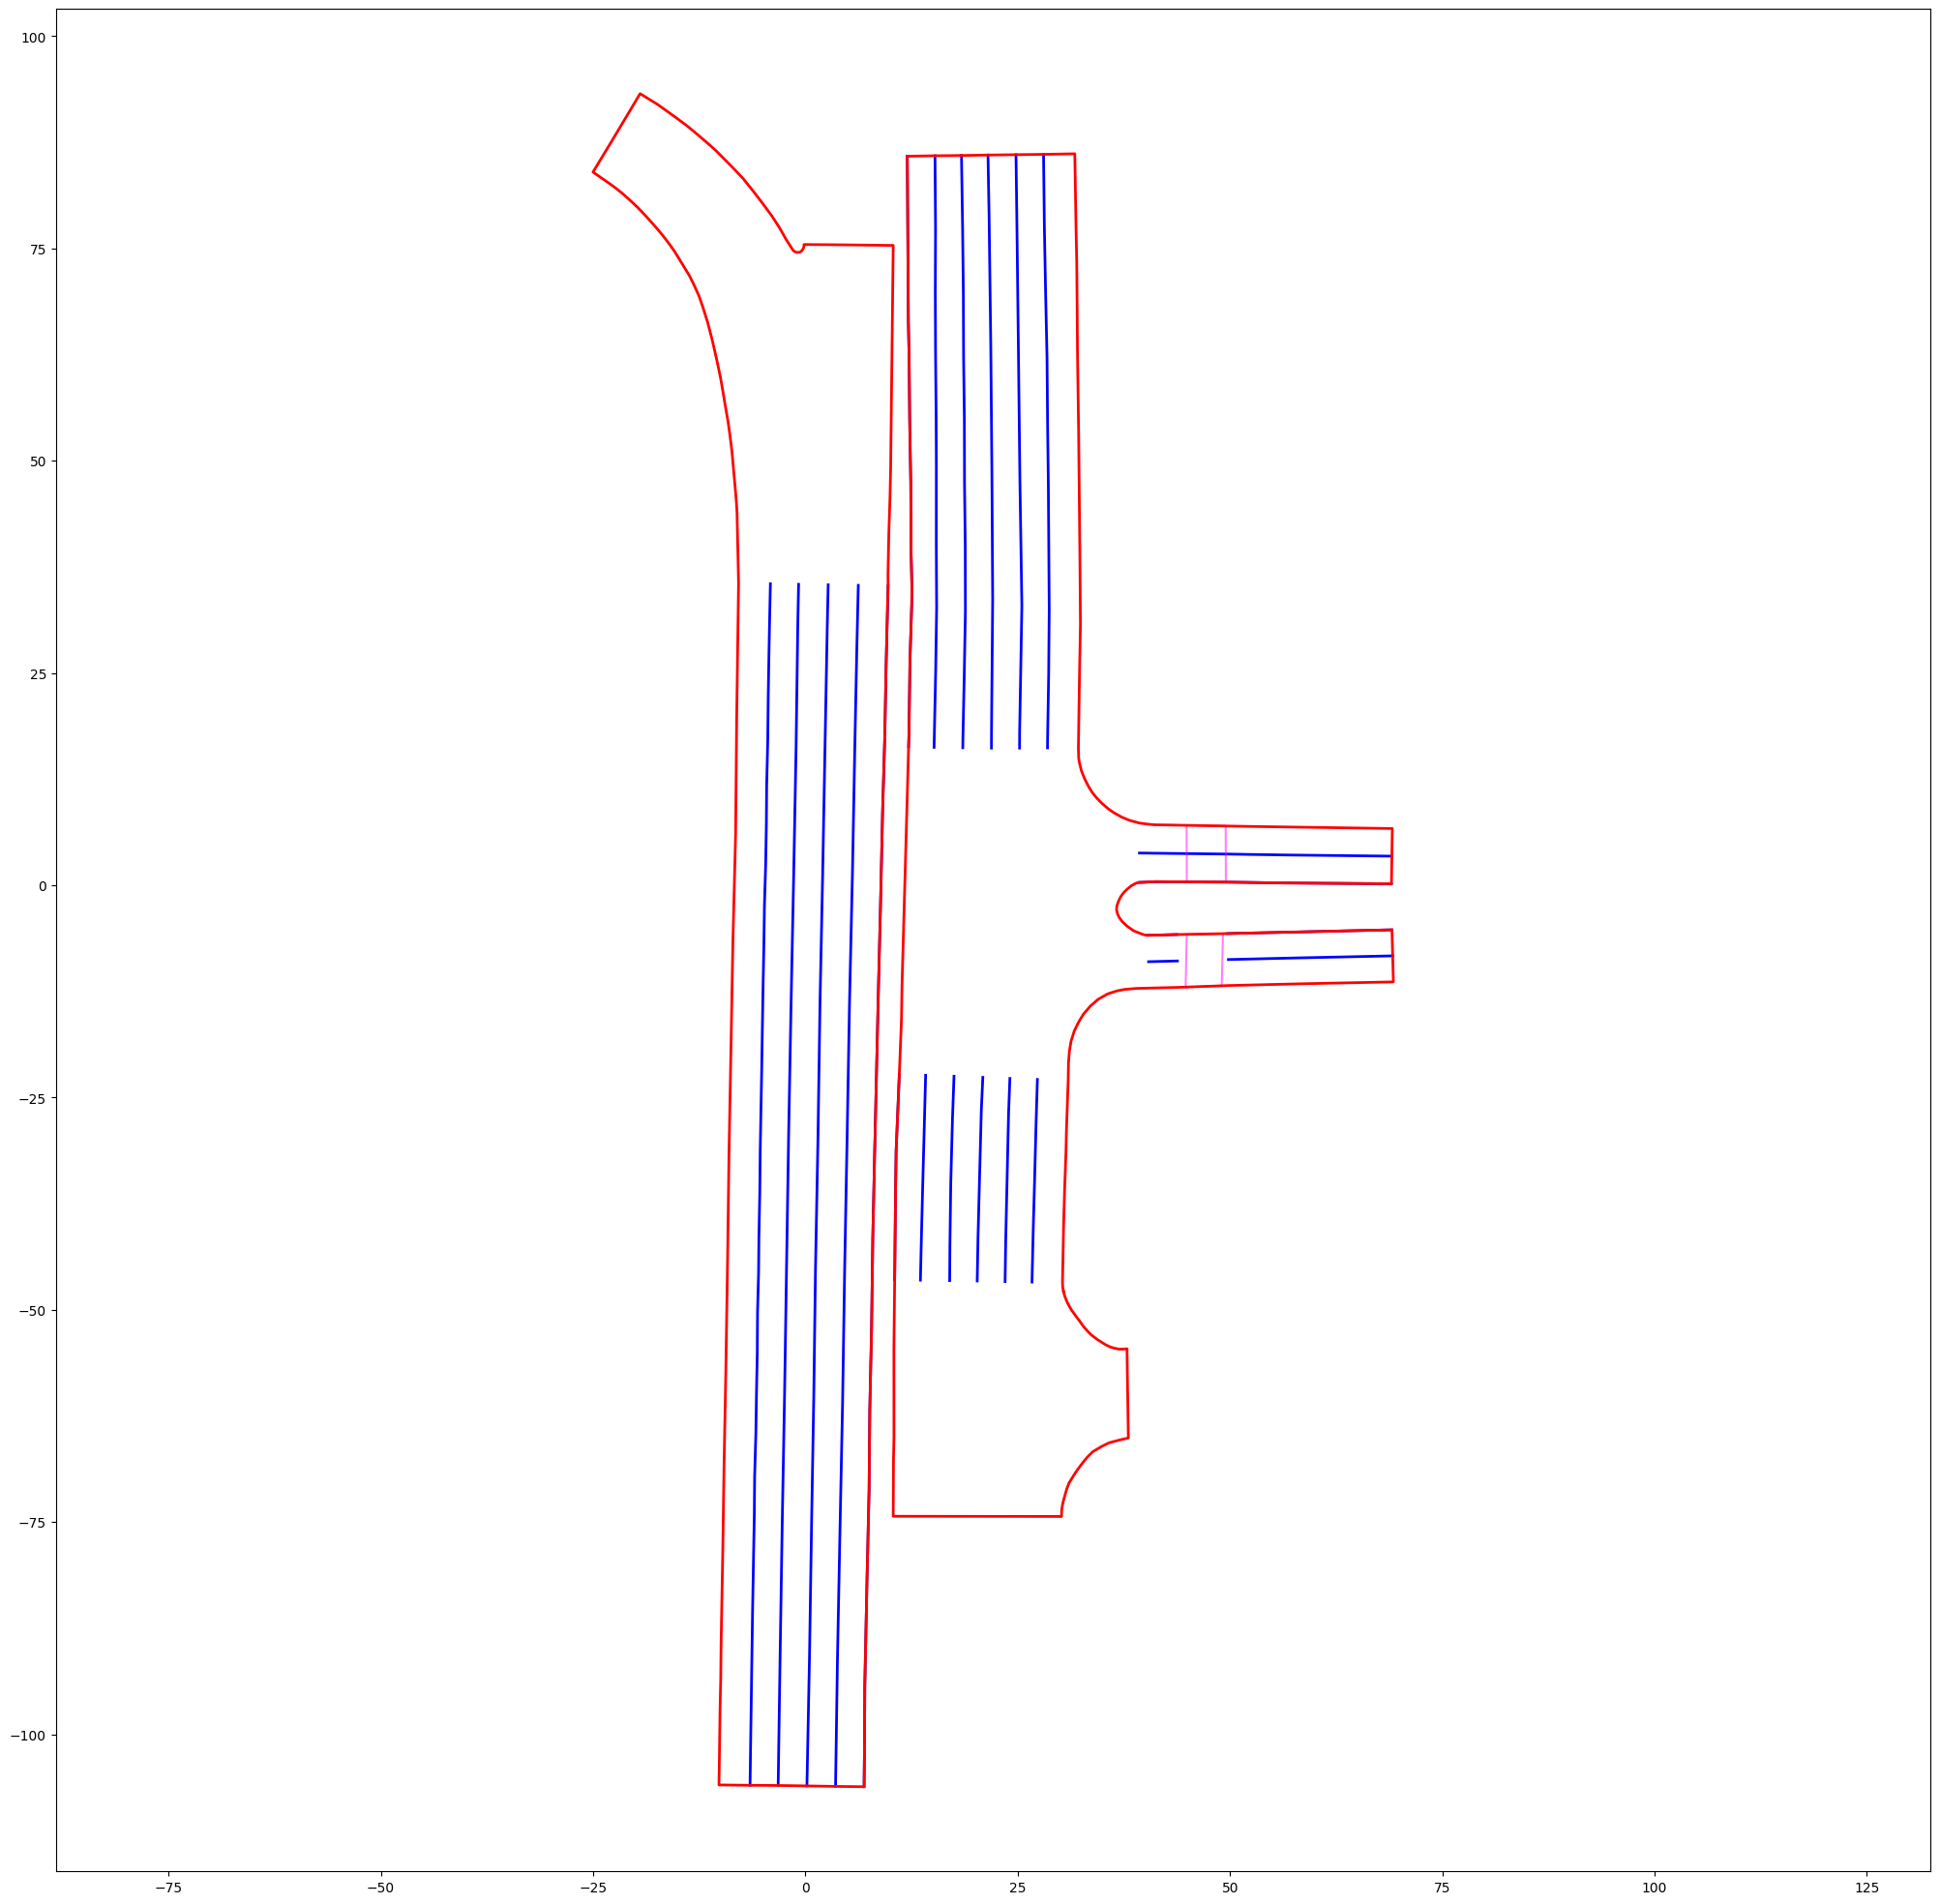

In [7]:
# map_features are in global frame

map_features = extract_map_features(map_api, (ego_pose_sample.x, ego_pose_sample.y), radius=radius)
visualize_map_features(map_features)

In [8]:
from typing import Tuple
from scipy.spatial.transform import Rotation as R



def calculate_map_scale(map_db, ego_pose_rec):

    map_layer = map_db.load_layer(ego_pose_rec.log.map_version, 'intensity')
    precision = map_layer.precision
    # to_pixel_coords = map_layer.to_pixel_coords
    map_scale: Tuple[float, ...] = (1.0 / precision, 1.0 / precision, 1.0)

    # We need to extract the rotation around the z-axis only. since we are cropping a 2D map.
    # Construct scipy rotation instance using the rotation matrix from quaternion.
    rotation = R.from_matrix(ego_pose_rec.quaternion.rotation_matrix.T)
    # Extract the angle of rotation around z-axis from the rotation.
    ego_rotation_angle = rotation.as_euler("zxy", degrees=True)[0]
    # Construct scipy rotation instance using ego_rotation_angle.

    xy_rotation = R.from_euler("z", ego_rotation_angle, degrees=True)
    print(xy_rotation)
    return map_scale, ego_rotation_angle
map_scale, angle = calculate_map_scale(mapdb, ego_pose_sample)
map_scale, angle


((10.0, 10.0, 1.0), 90.45023295310861)

In [9]:
def get_sd_types_with_shapes(ret):
    """
    Extract and print all SD.TYPE values along with their associated geometric shapes from the returned dictionary of map features.
    
    :param ret: The dictionary containing map features and their properties.
    :return: A dictionary where each key is an SD.TYPE and the value is a set of associated geometric shapes.
    """
    sd_type_shapes = {}  # Dictionary to store types and their shapes

    for key, value in ret.items():
        if SD.TYPE in value:
            sd_type = value[SD.TYPE]
            shapes = set()
            
            # Check for different shape types and add them to the set
            if SD.POLYLINE in value:
                shapes.add('Polyline')
            if SD.POLYGON in value:
                shapes.add('Polygon')

            # If the SD.TYPE already exists in the dictionary, update the set of shapes
            if sd_type in sd_type_shapes:
                sd_type_shapes[sd_type].update(shapes)
            else:
                sd_type_shapes[sd_type] = shapes

    return sd_type_shapes

# Example usage with the extract_map_features function
sd_types_with_shapes = get_sd_types_with_shapes(map_features)
for sd_type, shapes in sd_types_with_shapes.items():
    print(f"SD Type: {sd_type}; Shapes: {', '.join(shapes)}")

SD Type: ROAD_LINE_BROKEN_SINGLE_WHITE; Shapes: Polyline
SD Type: CROSSWALK; Shapes: Polygon
SD Type: ROAD_LINE_SOLID_SINGLE_WHITE; Shapes: Polyline


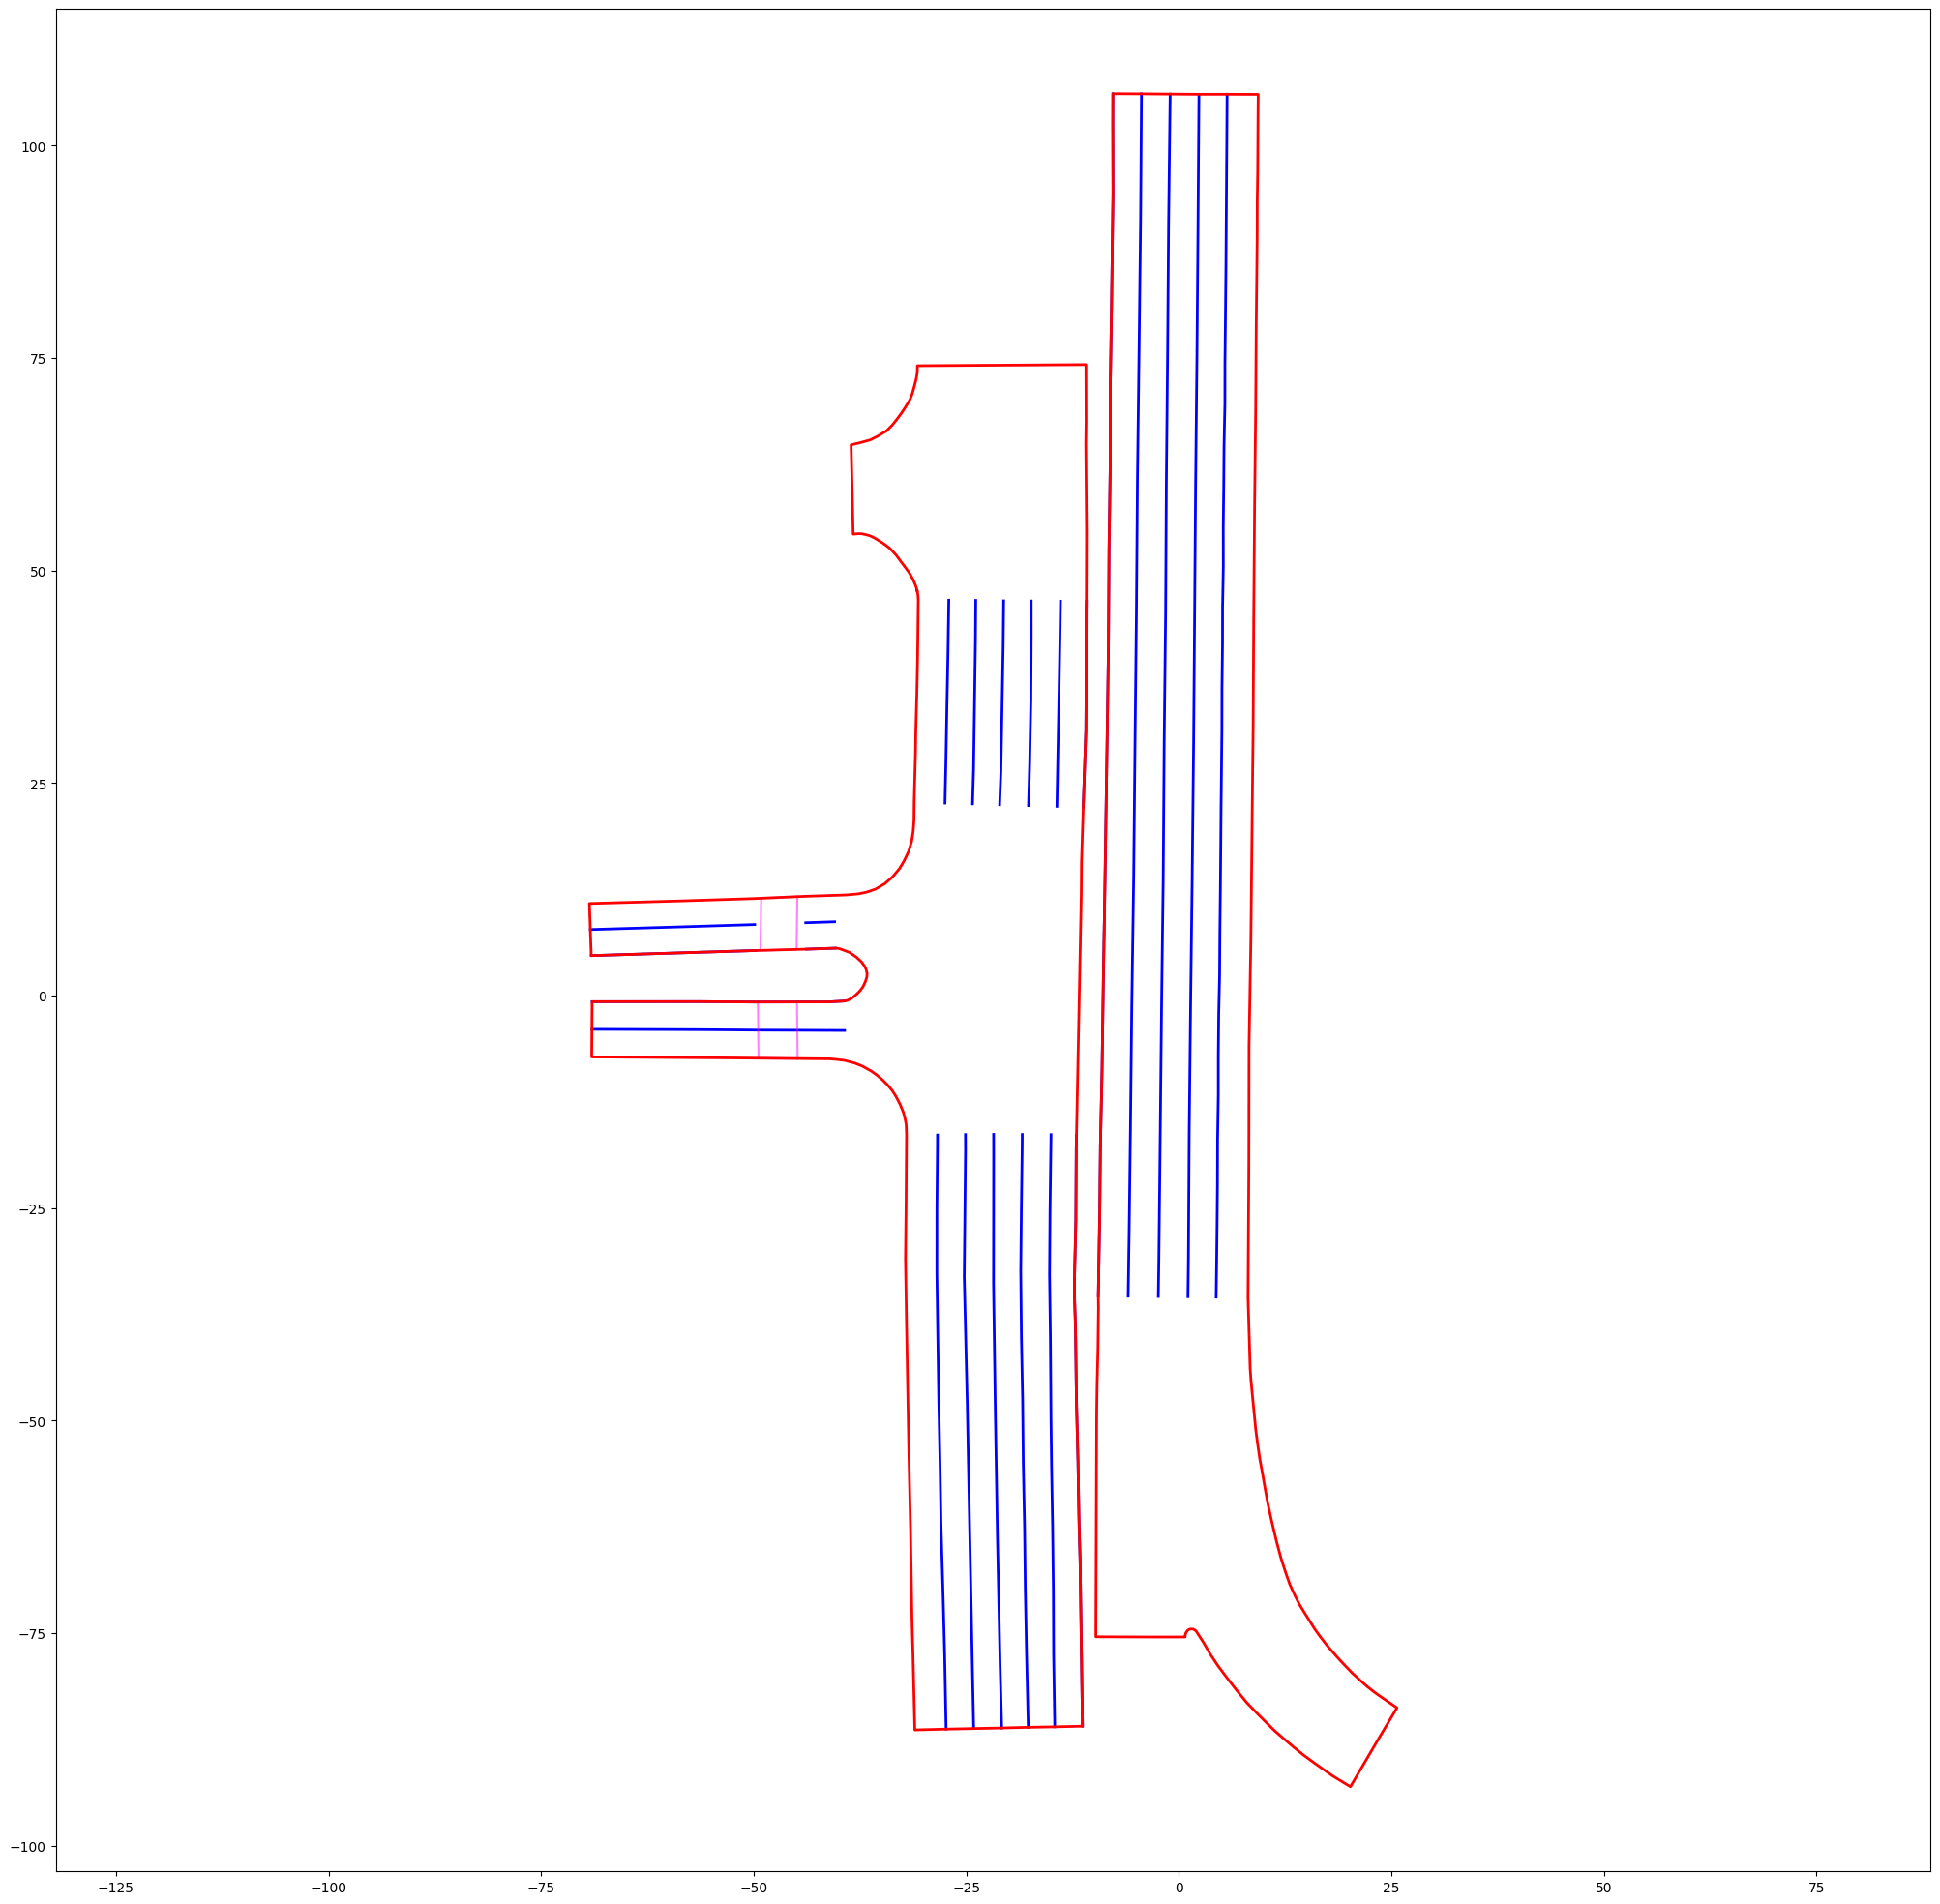

In [10]:
import numpy as np
import copy  # Import the copy module


#transform map features from global to map
def scale_rotate_translate_features(feat, scale_factor, rotation_angle_degrees, translation_vector):
    """
    Scales, rotates, and translates 'polyline' and 'polygon' coordinates for each feature in the dictionary,
    without altering the original data.

    :param map_features: Dictionary of features with 'polyline' and 'polygon' coordinates.
    :param scale_factor: The factor by which coordinates are to be scaled.
    :param rotation_angle_degrees: The angle in degrees to rotate the coordinates.
    :param translation_vector: The (x, y) vector by which to translate the coordinates.
    """
    # Create a deep copy of the features to avoid modifying the original data
    features = copy.deepcopy(feat)

    rotation_angle_radians = np.radians(rotation_angle_degrees)
    rotation_matrix = np.array([
        [np.cos(rotation_angle_radians), -np.sin(rotation_angle_radians)],
        [np.sin(rotation_angle_radians), np.cos(rotation_angle_radians)]
    ])

    for feature_id, data in features.items():
        # if data['type'] == 'ROAD_LINE_SOLID_SINGLE_WHITE' or data['type'] == 'ROAD_LINE_BROKEN_SINGLE_WHITE' or data['type'] == 'CROSSWALK':

            if 'polyline' in data:
                # Scale, rotate, and then translate the polyline
                # scaled_polyline = data['polyline'] * scale_factor
                # rotated_polyline = np.dot(scaled_polyline, rotation_matrix)
                # # translated_polyline = rotated_polyline + translation_vector
                # data['polyline'] = rotated_polyline # translated_polyline

                rotated_polyline = np.dot(data['polyline'], rotation_matrix)
                # translated_polyline = rotated_polyline + translation_vector
                data['polyline'] = rotated_polyline

            if 'polygon' in data:
                # Scale, rotate, and then translate the polygon
                # scaled_polygon = data['polygon'] * scale_factor
                # rotated_polygon = np.dot(scaled_polygon, rotation_matrix)
                # # translated_polygon = rotated_polygon + translation_vector
                # data['polygon'] = rotated_polygon #translated_polygon

                rotated_polygon = np.dot(data['polygon'], rotation_matrix)
                # # translated_polygon = rotated_polygon + translation_vector
                data['polygon'] = rotated_polygon

    return features

# Example usage with a translation vector to shift the origin to (1500, 1500)
translation_vector = np.array([radius*map_scale[0], radius*map_scale[0]])
rotated_features = scale_rotate_translate_features(map_features, map_scale[0], -angle-90, translation_vector) #152
visualize_map_features(rotated_features)

In [11]:
rotated_features

{'85674': {'type': 'ROAD_LINE_BROKEN_SINGLE_WHITE',
  'polyline': array([[ -9.45984899, -35.32171611],
         [ -9.29695494, -25.73328136],
         [ -9.21373292, -17.64162023],
         [ -9.02283059,  -8.78291382],
         [ -8.86637212,   2.16857971],
         [ -8.70426434,  11.70685818],
         [ -8.54544231,  22.16935213],
         [ -8.39853161,  31.87723197],
         [ -8.26588343,  41.31914017],
         [ -8.1994938 ,  52.61212074],
         [ -8.12821178,  57.36289671],
         [ -8.06768449,  61.81376882],
         [ -8.06177574,  67.50954178],
         [ -8.0612295 ,  71.09798928],
         [ -7.90380742,  81.34454179],
         [ -7.73535632,  94.30787541],
         [ -7.75605162, 102.69320781],
         [ -7.74825733, 106.10884526]])},
 '60444': {'type': 'ROAD_LINE_BROKEN_SINGLE_WHITE',
  'polyline': array([[ -5.95281499, -35.36200762],
         [ -5.83738606, -27.83678357],
         [ -5.68524247, -15.7184627 ],
         [ -5.5320888 ,  -1.57262832],
         [ 

In [12]:
from nuplan.database.nuplan_db_orm.utils import render_on_map
from nuplan.database.nuplan_db_orm.frame import Frame

def visualize_combined_map(lidarpc_rec, db, features, ax=None, radius=80.0):
    """
    Visualizes a combined map with both intensity map and road map features.
    
    :param lidarpc_rec: LidarPc record from NuPlanDB.
    :param db: Database instance.
    :param features: Road map features to overlay.
    :param ax: Matplotlib axis object to draw on.
    :param radius: Radius to consider around the lidar data.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 9))
    
    # Render intensity map first
    ax = render_on_map(
        lidarpc_rec=lidarpc_rec,
        db=db,
        boxes_lidar=lidarpc_rec.boxes(Frame.SENSOR),  # Assuming no boxes for simplicity; adjust as needed
        ego_poses=[lidarpc_rec.ego_pose],  # Assuming no ego poses; provide if available
        radius=radius,
        ax=ax,
        render_map_raster=False  # Change to True if you want to render raster map
    )
    
    # Overlay road map features
    type_to_color = {
        'ROAD_LINE_SOLID_SINGLE_WHITE': 'red',
        'ROAD_LINE_BROKEN_SINGLE_WHITE': 'blue',
        'CROSSWALK': 'magenta'
    }
    legend_labels = set()

    for feature_id, data in features.items():
        if data['type'] == 'ROAD_LINE_SOLID_SINGLE_WHITE' or data['type'] == 'ROAD_LINE_BROKEN_SINGLE_WHITE' or data['type'] == 'CROSSWALK':
            
            label = data['type'] if data['type'] not in legend_labels else None
            color = type_to_color[data['type']]

            # Plot polyline
            if 'polyline' in data:
                polyline = data['polyline']
                ax.plot(polyline[:, 0], polyline[:, 1], label=label, linewidth=2, color=color)
                if label:
                    legend_labels.add(data['type'])

            # Plot polygon as a filled area
            if 'polygon' in data:
                polygon = data['polygon']
                ax.plot(polygon[:, 0], polygon[:, 1], label=label, color=color, alpha=0.5)
                if label:
                    legend_labels.add(data['type'])

        else:
            continue

    # Finalize the plot
    ax.axis('off')
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

    return ax

In [13]:
visualize_combined_map(lidar_sample, nuplandb, rotated_features, radius=radius)

In [ ]:
import numpy as np
import torch
from nuplan.database.utils.geometry import view_points


# def apply_transformation(coords, extrinsic, intrinsic):
    # # Ensure coords is a numpy array
    # if not isinstance(coords, np.ndarray):
    #     coords = np.array(coords)
    # # coords = coords[:,[1,0]]
    # # coords[:,1] = -coords[:,1]
    # # Add a z-coordinate of zero (assuming all points lie on a z=0 plane) and a homogeneous coordinate (1)
    # dummy_pts = np.hstack([coords, np.zeros((coords.shape[0], 1))])

    # # Apply the transformation matrix to the homogeneous coordinates
    # # Transform_matrix should have the shape 4x4, and typically includes rotation and translation
    # points_in_cam_cor = np.dot(extrinsic[:3, :3].T, (dummy_pts.T - extrinsic[:3, 3].reshape(3, 1)))

    # # Extract the 3D camera coordinates (ignoring the homogeneous component)
    # points_in_cam_cor = points_in_cam_cor[:3, :]

    # # Filter out points that are behind the camera (z <= 0)
    # points_in_cam_cor = points_in_cam_cor[:, points_in_cam_cor[2, :] > 0]

    # if points_in_cam_cor.shape[1] > 1:
    #     points_on_image_cor = np.dot(intrinsic[:3, :3], points_in_cam_cor)
    #     points_on_image_cor /= points_on_image_cor[2, :]  # Perspective division
    #     points_on_image_cor = points_on_image_cor[:2, :].T.round().astype(int)
    # else:
    #     points_on_image_cor = np.array([])  # No points in front of the camera

    # return points_on_image_cor

def translate(feature, trans_vec):
    """
    Apply a translation vector to 3D points.
    :param points: <np.array> of shape (n, 3) representing n points in 3D space.
    :param trans_vec: <np.array> of shape (3,) representing the translation vector.
    :return: Translated points as a numpy array.
    """
    return feature + trans_vec

def rotate(feature, rot_matrix):
    """
    Apply a rotation matrix to 3D points.
    :param points: <np.array> of shape (n, 3) representing n points in 3D space.
    :param rot_matrix: <np.array> of shape (3, 3) representing the rotation matrix.
    :return: Rotated points as a numpy array.
    """
    return np.dot(feature, rot_matrix.T)

def transform(feature, trans_matrix, intrinsic_trans):
    """
    Apply a 4x4 transformation matrix to 3D points.
    :param points: <np.array> of shape (n, 2) representing n points in 3D space.
    :param trans_matrix: <np.array> of shape (4, 4) representing the 3D transformation matrix.
    :return: Transformed points as a numpy array.
    """
    if feature.shape[1] < 3:
        # add the z coordinates with zeros
        n = feature.shape[0]
        feat_3D = np.hstack([feature, np.zeros((n, 1))])
    else:
        feat_3D = copy.deepcopy(feature)

    if intrinsic_trans is False:
        feat_rotate = rotate(feat_3D, rot_matrix=trans_matrix[:3, :3])
        feat = translate(feat_rotate, trans_vec=trans_matrix[:3, 3])
    else:
        feat = rotate(feat_3D, rot_matrix=trans_matrix[:3, :3])
        feat = feat / (
                feat[-1, :].reshape(1, -1)
            )
        feat = feat[:2, :].T
        # feat = feat.int().numpy()

    return feat[:, :3]

def transform_features(features, transform_matrix, intrinsic_trans=False): #,view_matrix):
    tmp_features = copy.deepcopy(features)
    # tmp_features = tmp_features[2,0,1]
    # tmp_features[]
    for _, data in tmp_features.items():
        if 'polyline' in data:
            # data['polyline'] = apply_transformation(data['polyline'], transform_matrix,view_matrix)
            data['polyline'] = transform(data['polyline'], transform_matrix, intrinsic_trans) # ,view_matrix)

        if 'polygon' in data:
            # data['polygon']  = apply_transformation(data['polygon'], transform_matrix,view_matrix)
            data['polygon']  = transform(data['polygon'], transform_matrix, intrinsic_trans) # ,view_matrix)


    return tmp_features


In [ ]:
def project_to_image(features, intrinsics): #,view_matrix):
    tmp_features = copy.deepcopy(features)
    for _, data in tmp_features.items():
        if 'polyline' in data:
            # data['polyline'] = apply_transformation(data['polyline'], transform_matrix,view_matrix)
            data['polyline'] = view_points(data['polyline'][:3, :].T, intrinsics, normalize=True) # ,view_matrix)

        if 'polygon' in data:
            # data['polygon']  = apply_transformation(data['polygon'], transform_matrix,view_matrix)
            data['polygon']  = transform(data['polygon'][:3, :].T, intrinsics, normalize=True) # ,view_matrix)


    return tmp_features

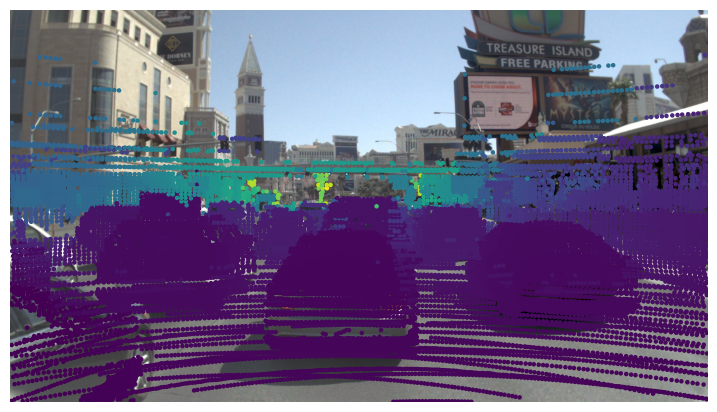

In [ ]:
from nuplan.database.nuplan_db_orm.rendering_utils import render_pointcloud_in_image
render_pointcloud_in_image(db=nuplandb,lidar_pc=lidar_sample)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def visualize_features(features):
    """
    Visualize map features including polylines and polygons using matplotlib,
    ensuring each type is only labeled once in the legend. Polygons are filled with color, and each data type has a unique color.
    
    :param features: Dictionary of features to visualize. Each key is an ID, each value is another dict with 'polyline' and 'polygon'.
    """
    fig, ax = plt.subplots(figsize=(25, 25))  # Adjust the plot size as needed
    ax.set_aspect('equal', adjustable='datalim')
    plt.grid(False)

    # Prepare color mapping for each type
    # color_map = plt.cm.viridis(np.linspace(0, 1, len(types)))  # Generate a color map
    type_to_color = {'ROAD_LINE_SOLID_SINGLE_WHITE': 'red',
                     'ROAD_LINE_BROKEN_SINGLE_WHITE': 'blue',
                     'CROSSWALK': 'magenta'}  # Map each type to a unique color

    legend_labels = set()  # Set to track labels already used in the legend

    for feature_id, data in features.items():
        if data['type'] == 'ROAD_LINE_SOLID_SINGLE_WHITE' or data['type'] == 'ROAD_LINE_BROKEN_SINGLE_WHITE' or data['type'] == 'CROSSWALK':
            
            label = data['type'] if data['type'] not in legend_labels else None
            color = type_to_color[data['type']]

            # Plot polyline
            if 'polyline' in data:
                # print(polyline)  # Print the polyline for verification
                polyline = data['polyline']
                # Plot the polyline
                if data['polyline'].size > 0:
                    ax.plot(polyline[:, 0], polyline[:, 1], label=label, linewidth=2, color=color)

                # Add to legend labels set if label is provided and not already included
                if label and data['type'] not in legend_labels:
                    legend_labels.add(data['type'])

            if 'polygon' in data:
                polygon = data['polygon']
                if data['polygon'].size > 0:
                    ax.plot(polygon[:, 0], polygon[:, 1], label=label,  linewidth=2,color=color)
                if label:
                    legend_labels.add(data['type'])

        else:
            continue
    # ax.set_xlim(0, image_sample.camera.width)
    # ax.set_ylim(image_sample.camera.height, 0)
    # ax.set_title(image_sample.camera.channel)        
    # plt.show()
    return ax

In [ ]:
# import numpy as np
# import copy

# def translate(feature, trans_vec):
#     """
#     Apply a translation vector to 3D points.
#     :param points: <np.array> of shape (n, 3) representing n points in 3D space.
#     :param trans_vec: <np.array> of shape (3,) representing the translation vector.
#     :return: Translated points as a numpy array.
#     """
#     return feature + trans_vec

# def rotate(feature, rot_matrix):
#     """
#     Apply a rotation matrix to 3D points.
#     :param points: <np.array> of shape (n, 3) representing n points in 3D space.
#     :param rot_matrix: <np.array> of shape (3, 3) representing the rotation matrix.
#     :return: Rotated points as a numpy array.
#     """
#     return np.dot(feature, rot_matrix.T)

# def transform(feature, trans_matrix, intrinsic_trans=False):
#     """
#     Apply a 4x4 transformation matrix to 3D points.
#     :param points: <np.array> of shape (n, 2) representing n points in 3D space.
#     :param trans_matrix: <np.array> of shape (4, 4) representing the 3D transformation matrix.
#     :return: Transformed points as a numpy array.
#     """
#     # add the z coordinates with zeros
#     n = feature.shape[0]
#     feat_3D = np.hstack([feature, np.zeros((n, 1))])
#     if intrinsic_trans is False:
#         feat_rotate = rotate(feat_3D, rot_matrix=trans_matrix[:3, :3])
#         feat_trans = translate(feat_rotate, trans_vec=trans_matrix[:3, 3])
#     else:
#         feat_rotate = rotate(feat_3D, rot_matrix=trans_matrix[:3, :3])

#     return feat_trans[:, :2]

In [ ]:
# type_to_int_map = {
#     'ROAD_LINE_SOLID_SINGLE_WHITE': 0,
#     'ROAD_LINE_BROKEN_SINGLE_WHITE': 1,
#     'CROSSWALK': 2
# }

# type_polyline_pairs = [(type_to_int_map[item['type']], item['polyline']) for item in lidarego_features.values()]
# type_polyline_pairs

In [ ]:
nuplandb.camera

Camera(8 entries):
--------------------------------------------------
token                       : 7ac95a6444805108
log_token                   : d908a069f1135360
translation                 : [-0.4866409369975697, -0.0005954995062043893, 1.4863210972954488]
intrinsic                   : [[1545.0, 0.0, 960.0], [0.0, 1545.0, 560.0], [0.0, 0.0, 1.0]]
width                       : 1920
height                      : 1080
model                       : DesignCore D3CM-IMX390
channel                     : CAM_B0
rotation                    : [-0.498582046231349, 0.5038506943063591, 0.49782257491778836, -0.4997230282116118]
distortion                  : [-0.356123, 0.172545, -0.00213, 0.000464, -0.05231]

token                       : ee7c6518f8f9570a
log_token                   : d908a069f1135360
translation                 : [1.670100095641242, -0.025874952985450953, 1.5226234965806427]
intrinsic                   : [[1545.0, 0.0, 960.0], [0.0, 1545.0, 560.0], [0.0, 0.0, 1.0]]
width        

8
1 [[  187   639]
 [-1261   808]]
-----
1 [[   15   641]
 [-1795   815]]
-----
1 [[ -171   643]
 [-2383   823]]
-----
1 [[ -336   645]
 [-2908   830]]
-----
1 [[-398  622]
 [-371  622]
 [-351  621]
 [-331  621]
 [-310  621]
 [-252  621]
 [-200  621]
 [-171  621]]
-----
1 [[-4485   736]
 [-3411   702]
 [-2688   679]
 [-2414   670]
 [-2167   663]
 [-1943   656]
 [-1762   651]
 [-1601   646]
 [-1484   642]
 [-1355   639]
 [-1279   637]
 [-1170   633]]
-----
1 [[-4297   738]
 [-3684   718]
 [-3191   701]
 [-2786   688]
 [-2445   677]
 [-2154   667]
 [-1902   659]
 [-1680   652]
 [-1484   646]
 [-1307   641]
 [-1148   636]]
-----
1 [[-510  729]
 [-174  688]
 [ 148  649]
 [ 401  619]
 [ 480  609]]
-----
1 [[-201  726]
 [   0  695]
 [ 142  674]
 [ 329  646]
 [ 571  609]]
-----
1 [[106 723]
 [253 693]
 [358 672]
 [495 644]
 [679 608]]
-----
1 [[437 720]
 [527 690]
 [590 670]
 [674 643]
 [779 607]]
-----
1 [[753 717]
 [786 688]
 [811 668]
 [844 641]
 [881 606]]
-----
1 [[1067  714]
 [1046  686

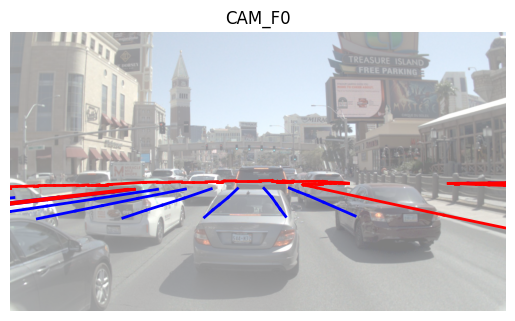

In [ ]:
from functools import reduce

import cv2

image_sample_list = lidar_pc_closest_image(nuplandb.lidar_pc[sample_idx])
print(len(image_sample_list))
image_sample = image_sample_list[0]

lidarego_features = copy.deepcopy(rotated_features)
global_features = transform_features(lidarego_features, lidar_sample.ego_pose.trans_matrix)
cameraego_features = transform_features(global_features, image_sample.ego_pose.trans_matrix_inv)

type_to_int_map = {
    'ROAD_LINE_SOLID_SINGLE_WHITE': 0, #red
    'ROAD_LINE_BROKEN_SINGLE_WHITE': 1, #blue
    'CROSSWALK': 2 #pink
}

type_polyline_pairs = []

for item in cameraego_features.values():
    # Explicitly check for 'polyline' and 'polygon' keys and choose appropriately
    if 'polyline' in item:
        geometry = item['polyline']
    elif 'polygon' in item:
        geometry = item['polygon']
    else:
        # If neither key is present, print a warning and continue to the next item
        print("Warning: No valid polyline or polygon data found for item:", item)
        continue  # Skip to the next iteration of the loop

    # Assuming 'type' is always present in the item
    type_polyline_pairs.append((type_to_int_map[item['type']], geometry))

rotation = R.from_quat(image_sample.camera.rotation)
rotation_matrix = rotation.as_matrix()
extrinsic = np.eye(4)  # start with an identity matrix
extrinsic[:3, :3] = rotation_matrix  # set the top-left 3x3 submatrix to the rotation matrix
extrinsic[:3, 3] = image_sample.camera.translation   
extrinsic = torch.Tensor(extrinsic)

intrinsic = np.eye(4)
intrinsic[:3,:3] = image_sample.camera.intrinsic_np
intrinsic = torch.Tensor(intrinsic)

z = 0
canvas = np.zeros((3, 900, 1600, 3), dtype=np.uint8)
fig, ax = plt.subplots()
ax = image_sample.render(nuplandb, with_3d_anns=False, ax =ax)
for gt_label_3d, gt_line_instance in type_polyline_pairs:
    pts = torch.Tensor(list(gt_line_instance))

    pts = pts[:, [1, 0]]
    pts[:, 1] = -pts[:, 1]
    dummy_pts = torch.cat([pts, torch.ones((pts.shape[0], 1)) * z], dim=-1)
    points_in_cam_cor = torch.matmul(
        extrinsic[:3, :3].T, (dummy_pts.T - extrinsic[:3, 3].reshape(3, -1))
    )
    points_in_cam_cor = points_in_cam_cor[:, points_in_cam_cor[2, :] > 0]
    # print(points_in_cam_cor)

    if points_in_cam_cor.shape[1] > 1:
            points_on_image_cor = intrinsic[:3, :3] @ points_in_cam_cor
            points_on_image_cor = points_on_image_cor / (
                points_on_image_cor[-1, :].reshape(1, -1)
            )
            points_on_image_cor = points_on_image_cor[:2, :].T
            points_on_image_cor = points_on_image_cor.int().numpy()

            # Select color based on the type
            if gt_label_3d == 0:
                color = 'red'  # Type 0 in red
            elif gt_label_3d == 1:
                color = 'blue'  # Type 1 in blue
            elif gt_label_3d == 2:
                color = 'magenta'  # Type 2 in magenta

            # Draw lines
            for i in range(len(points_on_image_cor) - 1):
                ax.plot(
                    [points_on_image_cor[i][0], points_on_image_cor[i + 1][0]],
                    [points_on_image_cor[i][1], points_on_image_cor[i + 1][1]],
                    color=color,
                    linewidth=2
                )
    else:
        points_on_image_cor = []
    print(gt_label_3d, points_on_image_cor)
    print('-----')


plt.axis('off')  # Turn off axis if not required
plt.show()  # Show the plot       
    
    

In [ ]:
print(canvas.shape)  # Expected: (3, 900, 1600, 3)
if layer_index < canvas.shape[0]:
    print(canvas[layer_index].shape)  # Expected: (900, 1600, 3)
else:
    print(f"Layer index {layer_index} out of bounds")

(3, 900, 1600, 3)


NameError: name 'layer_index' is not defined

In [ ]:
# lidar_ego_to_global = lidar_sample.ego_pose.trans_matrix

from functools import reduce
lidarego_features = copy.deepcopy(rotated_features)

type_polyline_pairs = [(item['type'], item['polyline']) for item in lidarego_features.values()]
type_polyline_pairs
# global_features = transform_features(lidarego_features, lidar_sample.ego_pose.trans_matrix)

image_sample_list = lidar_pc_closest_image(nuplandb.lidar_pc[0])
image_sample = image_sample_list[0]

rotation = R.from_quat(image_sample.camera.rotation)
rotation_matrix = rotation.as_matrix()
extrinsic_matrix = np.eye(4)  # start with an identity matrix
extrinsic_matrix[:3, :3] = rotation_matrix  # set the top-left 3x3 submatrix to the rotation matrix
extrinsic_matrix[:3, 3] = image_sample.camera.translation   

# global_features = transform_features(lidarego_features, lidar_sample.ego_pose.trans_matrix)
# cameraego_features = transform_features(global_features, image_sample.ego_pose.trans_matrix_inv)
# camera_features = transform_features(cameraego_features,image_sample.camera.trans_matrix_inv)

camera_features = transform_features(lidarego_features,transform)

# image_features = transform_features(camera_features,image_sample.camera.intrinsic_np, intrinsic_trans=True)

image_features = project_to_image(camera_features,image_sample.camera.intrinsic_np)
# lidarego_features = transform_features(transformed_features, lidar_sample.ego_pose.trans_matrix_inv)
# rot_features = scale_rotate_translate_features(transformed_features, map_scale[0], angle-90, translation_vector) #152
# camera_features['68353']['polyline'].shape
# visualize_features(image_features)

ax = visualize_features(camera_features)
image_sample.render(nuplandb, with_3d_anns=False,ax=ax)
plt.show()
# image_features

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
# transform map_features from global to image frame
# global -> ego -> camera -> image

image_sample_list = lidar_pc_closest_image(nuplandb.lidar_pc[800])
image_sample = image_sample_list[0]

rotation = R.from_quat(image_sample.camera.rotation)
rotation_matrix = rotation.as_matrix()
extrinsic_matrix = np.eye(4)  # start with an identity matrix
extrinsic_matrix[:3, :3] = rotation_matrix  # set the top-left 3x3 submatrix to the rotation matrix
extrinsic_matrix[:3, 3] = image_sample.camera.translation     
# extrinsic_matrix

# for image_sample in image_sample_list:
# ego_to_camera = image_sample.camera.trans_matrix_inv
# global_to_ego = image_sample.ego_pose.trans_matrix_inv
# extrinsic_matrix = np.dot(ego_to_camera, global_to_ego)

view_matrix = image_sample.camera.intrinsic_np

global_map_features = copy.deepcopy(rotated_features)
transformed_features = transform_features(global_map_features, ego_to_camera, view_matrix)
print(transformed_features)

ax = visualize_features(transformed_features)
image_sample.render(nuplandb, with_3d_anns=False,ax=ax)
plt.show()
transformed_features.values()

NameError: name 'ego_to_camera' is not defined

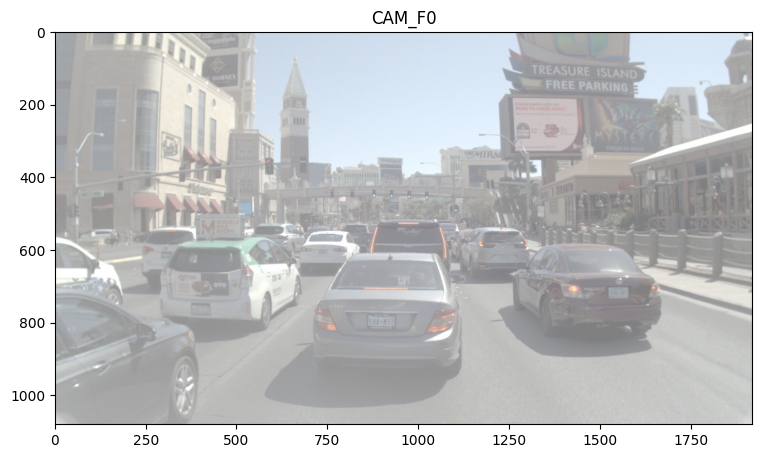

In [ ]:
image_sample.render(nuplandb,with_3d_anns=False)

In [ ]:
# def render_features_to_image():

In [ ]:
from functools import reduce

global_to_ego = lidar_sample.ego_pose.trans_matrix_inv
ego_to_lidar = lidar_sample.lidar.trans_matrix_inv  # type: ignore
lidar_to_image = reduce(
        np.dot,
        [
            img.camera.trans_matrix_inv,
            img.ego_pose.trans_matrix_inv,
            lidar_pc.ego_pose.trans_matrix,
            lidar_pc.lidar.trans_matrix,
        ],
    )

NameError: name 'img' is not defined